# Cython vs Python vs Numba: a simple study case

In this notebook I present a simple study case of cython versus python versus Numba performance. Three problems are considered:

1. A simple operation involving 1d arrays (e.g, compute the mean of a 1d array)
2. A more complex problem involving a 2d array: This is the classical computation of a pedestal, using the mean of the waveform, and then returning the pedestal-subtracted waveform normalized to some calibration constants. The data is a 2d array, with one axis running over sensors and the other representing each sensor waveform.
3. An even more complex problem where a MAU is used to compute the pedestal and then subtract it or return values above pedetal + MAU


In [8]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import numpy.testing as npt
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

2017-12-04 16:29:27
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from numba import jit

In [3]:
from scipy import signal

In [4]:
%load_ext Cython

## 1.  Simple operation (mean of a vector): python, cython and python + numpy

In [5]:
mu, sigma = 0, 0.1
s = np.random.normal(mu, sigma, 10000)

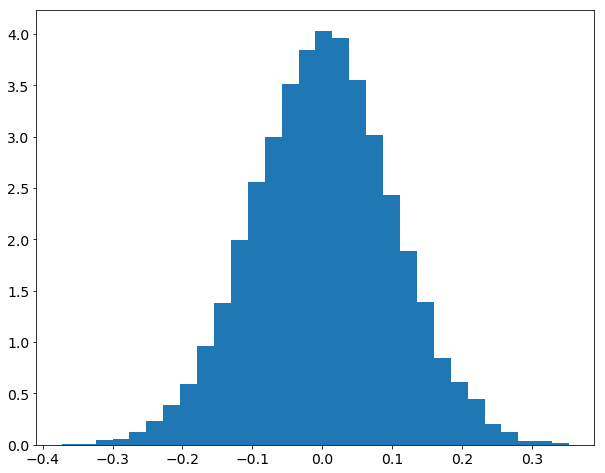

In [6]:
count, bins, ignored = plt.hist(s, 30, normed=True)

### Python

In [7]:
def python_mean(v):
    """Compute the mean of vector v using loop"""
    pmean = 0
    lv = len(v)
    for k in range(lv):
        pmean += v[k]
    pmean /= lv
    return pmean

#### Check that mean is close to zero 

In [11]:
npt.assert_allclose(python_mean(s), 0, rtol=1e-01, atol=1e-01)

#### Time performance

In [17]:
t_python_mean = %timeit -o python_mean(s)

1.39 ms ± 39.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
t_python_mean.best

0.001342250508023426

### Using python + numpy

In [19]:
t_python_np_mean = %timeit -o np.mean(s)

8.47 µs ± 223 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [238]:
t_python_mean.best/ t_python_np_mean.best 

164.80898206977096

### Using cython

In [25]:
%%cython 
cpdef float cython_mean(double [:] v):
    """Compute the mean of vector v using loop"""
    cdef float pmean = 0
    cdef int lv = len(v)
    cdef int k
    for k in range(lv):
        pmean += v[k]
    pmean /= lv
    return pmean


#### Check that result is identical to python function

In [26]:
npt.assert_allclose(python_mean(s), cython_mean(s), rtol=1e-05, atol=1e-05)

In [31]:
t_cython_mean = %timeit -o cython_mean(s)

44.6 µs ± 4.94 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [239]:
t_python_mean.best / t_cython_mean.best

37.19806875829442

In [240]:
t_python_np_mean.best / t_cython_mean.best

0.22570413512139054

#### Cython speed is 20 % of python + np!

### Using numba

In [35]:
numba_mean = jit(python_mean)

In [36]:
npt.assert_allclose(python_mean(s), numba_mean(s), rtol=1e-05, atol=1e-05)

In [37]:
t_numba_mean = %timeit -o numba_mean(s)

10.5 µs ± 150 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [241]:
t_python_np_mean.best / t_numba_mean.best

0.7895204763178433

#### Numba is essentially as fast (but not faster) than np for this simple problem 

### Summary of performance for a simple problem

In [44]:
print("""
python \t \t {}
pthon + np \t {}
cython \t\t {}
numba \t\t {}""".format(t_python_mean.best / t_python_mean.best, 
                     t_python_mean.best / t_python_np_mean.best, 
                     t_python_mean.best / t_cython_mean.best,
                     t_python_mean.best / t_numba_mean.best ))


python 	 	 1.0
pthon + np 	 164.80898206977096
cython 		 37.19806875829442
numba 		 130.12006602518446


## 2. A more realistic case. Subtract baseline and normalise to calibration constants

### Data definition: consider an array sipm of 40 sipm, with a waveform of 100 samples

In [129]:
nsipm = 40
wfl = 1000
sipm = np.zeros(nsipm * wfl, dtype=np.int16)
sipm = np.reshape(sipm,(nsipm,wfl))
for i in range(nsipm):
    sipm[i,:] = np.random.normal(100+i*10, 1, wfl)

print('sipm array = {}'.format(sipm))
NSiPM = sipm.shape[0]
NSiWF = sipm.shape[1]
print('NSiPM = {}, NSiWF = {}'.format(NSiPM, NSiWF))
print('baselines = {}'.format(np.mean(sipm,axis=1)))

sipm array = [[100  98  99 ..., 100 100 100]
 [109 109 111 ..., 109 109 109]
 [120 119 120 ..., 119 119 121]
 ..., 
 [470 468 471 ..., 469 469 471]
 [480 479 480 ..., 481 479 479]
 [491 490 488 ..., 488 490 489]]
NSiPM = 40, NSiWF = 1000
baselines = [  99.494  109.525  119.531  129.552  139.508  149.472  159.55   169.49
  179.55   189.462  199.568  209.464  219.522  229.486  239.548  249.57
  259.473  269.493  279.511  289.402  299.499  309.588  319.469  329.523
  339.522  349.545  359.456  369.508  379.538  389.45   399.525  409.472
  419.493  429.504  439.488  449.456  459.508  469.504  479.499  489.507]


In [130]:
np.mean(sipm, axis=1)

array([  99.494,  109.525,  119.531,  129.552,  139.508,  149.472,
        159.55 ,  169.49 ,  179.55 ,  189.462,  199.568,  209.464,
        219.522,  229.486,  239.548,  249.57 ,  259.473,  269.493,
        279.511,  289.402,  299.499,  309.588,  319.469,  329.523,
        339.522,  349.545,  359.456,  369.508,  379.538,  389.45 ,
        399.525,  409.472,  419.493,  429.504,  439.488,  449.456,
        459.508,  469.504,  479.499,  489.507])

### And calibration constants for each SiPM

In [131]:
adc_to_pes = np.abs(np.random.normal(1, 0.01, nsipm))
print('adc_to_pes = {}'.format(adc_to_pes))

adc_to_pes = [ 1.00188173  1.00011053  0.9940998   1.0035543   1.00868826  0.98695399
  1.00040184  0.99958598  0.97614018  1.01267556  0.99830305  0.9951432
  0.99822443  0.99608194  1.00281689  0.99461701  1.00983247  0.99373154
  0.99825226  0.99993601  1.01105532  0.99962493  1.00466351  0.99673651
  0.99607507  0.99378755  0.99920661  1.00223458  0.98755582  0.99089838
  1.02236777  1.00375817  0.99661337  0.99549016  0.98818035  1.01495367
  1.01647804  0.98295486  1.00184541  0.99302345]


## Subtract baseline and normalize to adc

### Python

In [132]:
def python_subtract_baseline_and_normalize(sipm, adc_to_pes):
    
    NSiPM = sipm.shape[0]
    NSiWF = sipm.shape[1]
    siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
   
    for j in range(NSiPM):
        pmean = 0
        for k in range(NSiWF):
            pmean += sipm[j,k]
        pmean /= NSiWF
        
        for k in range(NSiWF):
                siwf[j,k] = (sipm[j,k] - pmean) / adc_to_pes[j]
        
    
    return siwf 

In [133]:
npt.assert_allclose(np.mean(python_subtract_baseline_and_normalize(sipm, adc_to_pes)), 0, 
                            rtol=1e-05, atol=1e-05)

In [134]:
t_python_subtract_baseline_and_normalize = %timeit -o python_subtract_baseline_and_normalize(sipm, adc_to_pes)

109 ms ± 6.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Python: using numpy

In [135]:
def np_subtract_baseline_and_normalize(sipm, adc_to_pes):
    NSiPM = sipm.shape[0]
    NSiWF = sipm.shape[1]
    siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
    bl = np.mean(sipm, axis=1)
    for i in range(NSiPM):
        siwf[i] = (sipm[i] - bl[i]) / adc_to_pes[i]
    
    return siwf

In [136]:
npt.assert_allclose(np.mean(np_subtract_baseline_and_normalize(sipm, adc_to_pes)), 0, 
                            rtol=1e-05, atol=1e-05)

In [137]:
np_subtract_baseline_and_normalize(sipm, adc_to_pes)

array([[ 0.50504963, -1.49119397, -0.49307217, ...,  0.50504963,
         0.50504963,  0.50504963],
       [-0.52494198, -0.52494198,  1.47483698, ..., -0.52494198,
        -0.52494198, -0.52494198],
       [ 0.47178362, -0.5341516 ,  0.47178362, ..., -0.5341516 ,
        -0.5341516 ,  1.47771884],
       ..., 
       [ 0.504601  , -1.53008044,  1.52194172, ..., -0.51273972,
        -0.51273972,  1.52194172],
       [ 0.50007715, -0.49808084,  0.50007715, ...,  1.49823514,
        -0.49808084, -0.49808084],
       [ 1.50348917,  0.4964636 , -1.51758753, ..., -1.51758753,
         0.4964636 , -0.51056196]])

In [138]:
t_np_subtract_baseline_and_normalize = %timeit -o np_subtract_baseline_and_normalize(sipm, adc_to_pes)

338 µs ± 7.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Getting rid of loop

In [139]:
def np2_subtract_baseline_and_normalize(sipm, adc_to_pes):
    NSiPM = sipm.shape[0]
    NSiWF = sipm.shape[1]
    siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
    bl = np.mean(sipm, axis=1)
    return (sipm - bl[:, np.newaxis]) / adc_to_pes[:, np.newaxis]
    

In [140]:
npt.assert_allclose(np.mean(np2_subtract_baseline_and_normalize(sipm, adc_to_pes)), 0, 
                            rtol=1e-05, atol=1e-05)

In [141]:
np2_subtract_baseline_and_normalize(sipm, adc_to_pes)

array([[ 0.50504963, -1.49119397, -0.49307217, ...,  0.50504963,
         0.50504963,  0.50504963],
       [-0.52494198, -0.52494198,  1.47483698, ..., -0.52494198,
        -0.52494198, -0.52494198],
       [ 0.47178362, -0.5341516 ,  0.47178362, ..., -0.5341516 ,
        -0.5341516 ,  1.47771884],
       ..., 
       [ 0.504601  , -1.53008044,  1.52194172, ..., -0.51273972,
        -0.51273972,  1.52194172],
       [ 0.50007715, -0.49808084,  0.50007715, ...,  1.49823514,
        -0.49808084, -0.49808084],
       [ 1.50348917,  0.4964636 , -1.51758753, ..., -1.51758753,
         0.4964636 , -0.51056196]])

In [142]:
t_np2_subtract_baseline_and_normalize = %timeit -o np2_subtract_baseline_and_normalize(sipm, adc_to_pes)

169 µs ± 2.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [242]:
t_python_subtract_baseline_and_normalize.best  / t_np_subtract_baseline_and_normalize.best

320.88063170005813

In [243]:
t_python_subtract_baseline_and_normalize.best  / t_np2_subtract_baseline_and_normalize.best

623.8917313453583

#### NB! np_subtract_baseline_and_normalize does a partial vectorization of code, while np2_subtract_baseline_and_normalize does a full vectorization, gaining a factor of two in performance

### Cython

In [145]:
%%cython 
cimport numpy as np
import  numpy as np

cdef double cmean(double [:] v):
    cdef int  k
    cdef int N = len(v)
    cdef double pmean = 0
    
    for k in range(N):
        pmean += v[k]
    pmean /= N
    return pmean

cpdef cython_subtract_baseline_and_normalize(np.ndarray[np.int16_t, ndim=2]sipm, 
                                                            np.ndarray[np.float64_t, ndim=1] adc_to_pes):
    cdef int NSiPM = sipm.shape[0]
    cdef int NSiWF = sipm.shape[1]
    cdef double [:, :] SiWF = sipm.astype(np.double)
    cdef double [:, :] siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
    cdef double [:]    bl = np.zeros(NSiPM)
   
    cdef int j, k
    cdef double pmean
    for j in range(NSiPM):
        pmean = cmean(SiWF[j])
        
        for k in range(NSiWF):
                siwf[j,k] = (SiWF[j,k] - pmean) / adc_to_pes[j]
        
    return np.asarray(siwf) 




In [146]:
npt.assert_allclose(np.mean(cython_subtract_baseline_and_normalize(sipm, adc_to_pes)), 0, 
                            rtol=1e-05, atol=1e-05)

In [147]:
cython_subtract_baseline_and_normalize(sipm, adc_to_pes)

array([[ 0.50504963, -1.49119397, -0.49307217, ...,  0.50504963,
         0.50504963,  0.50504963],
       [-0.52494198, -0.52494198,  1.47483698, ..., -0.52494198,
        -0.52494198, -0.52494198],
       [ 0.47178362, -0.5341516 ,  0.47178362, ..., -0.5341516 ,
        -0.5341516 ,  1.47771884],
       ..., 
       [ 0.504601  , -1.53008044,  1.52194172, ..., -0.51273972,
        -0.51273972,  1.52194172],
       [ 0.50007715, -0.49808084,  0.50007715, ...,  1.49823514,
        -0.49808084, -0.49808084],
       [ 1.50348917,  0.4964636 , -1.51758753, ..., -1.51758753,
         0.4964636 , -0.51056196]])

In [148]:
t_cython_subtract_baseline_and_normalize = %timeit -o cython_subtract_baseline_and_normalize(sipm, adc_to_pes)

167 µs ± 1.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [244]:
t_python_subtract_baseline_and_normalize.best  / t_cython_subtract_baseline_and_normalize.best

620.5278778529091

### Cython + np

In [150]:
%%cython 
cimport numpy as np
import  numpy as np

cpdef cython_np_subtract_baseline_and_normalize(np.ndarray[np.int16_t, ndim=2]sipm, 
                                                            np.ndarray[np.float64_t, ndim=1] adc_to_pes):
    cdef int NSiPM = sipm.shape[0]
    bl = np.zeros(NSiPM)
   
   
    bl = np.mean(sipm, axis=1)
    return (sipm - bl[:, np.newaxis]) / adc_to_pes[:, np.newaxis]


In [151]:
npt.assert_allclose(np.mean(cython_np_subtract_baseline_and_normalize(sipm, adc_to_pes)), 0, 
                            rtol=1e-05, atol=1e-05)

In [152]:
cython_np_subtract_baseline_and_normalize(sipm, adc_to_pes)

array([[ 0.50504963, -1.49119397, -0.49307217, ...,  0.50504963,
         0.50504963,  0.50504963],
       [-0.52494198, -0.52494198,  1.47483698, ..., -0.52494198,
        -0.52494198, -0.52494198],
       [ 0.47178362, -0.5341516 ,  0.47178362, ..., -0.5341516 ,
        -0.5341516 ,  1.47771884],
       ..., 
       [ 0.504601  , -1.53008044,  1.52194172, ..., -0.51273972,
        -0.51273972,  1.52194172],
       [ 0.50007715, -0.49808084,  0.50007715, ...,  1.49823514,
        -0.49808084, -0.49808084],
       [ 1.50348917,  0.4964636 , -1.51758753, ..., -1.51758753,
         0.4964636 , -0.51056196]])

In [153]:
t_cython_np_subtract_baseline_and_normalize = %timeit -o cython_np_subtract_baseline_and_normalize(sipm, adc_to_pes)

148 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Numba

In [154]:
numba_subtract_baseline_and_normalize = jit(python_subtract_baseline_and_normalize)

In [155]:
t_numba_subtract_baseline_and_normalize = %timeit -o numba_subtract_baseline_and_normalize(sipm, adc_to_pes)

132 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [156]:
numba_np_subtract_baseline_and_normalize = jit(np_subtract_baseline_and_normalize)

In [157]:
t_numba_np_subtract_baseline_and_normalize = %timeit -o numba_np_subtract_baseline_and_normalize(sipm, adc_to_pes)

121 µs ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Summary of performance for a problem involving array operations (subtract baseline and normalize)

In [245]:
print("""
python \t \t {}
pthon + np \t {}
cython \t\t {}
numba \t\t {}
numba (np) \t {}""".format(t_python_subtract_baseline_and_normalize.best / t_python_subtract_baseline_and_normalize.best, 
                     t_python_subtract_baseline_and_normalize.best / t_np2_subtract_baseline_and_normalize.best, 
                     t_python_subtract_baseline_and_normalize.best / t_cython_subtract_baseline_and_normalize.best,
                     t_python_subtract_baseline_and_normalize.best / t_numba_subtract_baseline_and_normalize.best,
                     t_python_subtract_baseline_and_normalize.best / t_numba_np_subtract_baseline_and_normalize.best))


python 	 	 1.0
pthon + np 	 623.8917313453583
cython 		 620.5278778529091
numba 		 789.8176703043019
numba (np) 	 963.2324938847604


#### Similar results for python + np and cython, with numba improving both 

## 3. USING MAUs

### Python version

In [228]:
def python_signal_above_thr_mau(sipm, adc_to_pes, thr, n_MAU=100):
    

    NSiPM = sipm.shape[0]
    NSiWF = sipm.shape[1]
    SiWF = sipm.astype(np.double)
    siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
    MAU = np.array(np.ones(n_MAU), dtype = np.double) * (1 / n_MAU)
    MAU_ = np.zeros(NSiWF, dtype=np.double)
    thrs = np.full(NSiPM, thr)
    
    for j in range(NSiPM):
        if adc_to_pes[j] == 0:
            continue

        # compute and subtract the baseline
        pmean = python_mean(SiWF[j])

        for k in range(NSiWF):
            SiWF[j,k] = SiWF[j,k] - pmean
        MAU_ = signal.lfilter(MAU, 1, SiWF[j,:])
        
        
        # threshold using the MAU
        for k in range(NSiWF):
            if SiWF[j,k]  > MAU_[k] + thrs[j] * adc_to_pes[j]:
                siwf[j,k] = SiWF[j,k] / adc_to_pes[j]

    return siwf

In [229]:
python_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=100)

array([[ 0.50504963,  0.        ,  0.        , ...,  0.50504963,
         0.50504963,  0.50504963],
       [ 0.        ,  0.        ,  1.47483698, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.47178362,  0.        ,  0.47178362, ...,  0.        ,
         0.        ,  1.47771884],
       ..., 
       [ 0.504601  ,  0.        ,  1.52194172, ...,  0.        ,
         0.        ,  1.52194172],
       [ 0.50007715,  0.        ,  0.50007715, ...,  1.49823514,
         0.        ,  0.        ],
       [ 1.50348917,  0.4964636 ,  0.        , ...,  0.        ,
         0.4964636 ,  0.        ]])

In [169]:
t_python_signal_above_thr_mau = %timeit -o python_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=100)

49.6 ms ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Vectorized python

In [221]:
def np_signal_above_thr_mau(sipm, adc_to_pes, thr, n_MAU=100):
    

    NSiPM = sipm.shape[0]
    NSiWF = sipm.shape[1]
    SiWF = sipm.astype(np.double)
    MAU = np.array(np.ones(n_MAU), dtype = np.double) * (1 / n_MAU)
    MAU_ = np.zeros(NSiWF, dtype=np.double)
    thrs = np.full(NSiPM, thr)
    
    SiWF = SiWF[adc_to_pes > 0]
    
    pmean = np.mean(sipm, axis=1)
    SiWF  = SiWF  - pmean[:, np.newaxis]
    MAU_ = signal.lfilter(MAU, 1, SiWF)
    
    return np.where(SiWF  > MAU_+ thrs[:, np.newaxis] * adc_to_pes[:, np.newaxis], 
             SiWF / adc_to_pes[:, np.newaxis], 0)
    
    return siwf
    

In [222]:
np_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=100)

array([[ 0.50504963,  0.        ,  0.        , ...,  0.50504963,
         0.50504963,  0.50504963],
       [ 0.        ,  0.        ,  1.47483698, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.47178362,  0.        ,  0.47178362, ...,  0.        ,
         0.        ,  1.47771884],
       ..., 
       [ 0.504601  ,  0.        ,  1.52194172, ...,  0.        ,
         0.        ,  1.52194172],
       [ 0.50007715,  0.        ,  0.50007715, ...,  1.49823514,
         0.        ,  0.        ],
       [ 1.50348917,  0.4964636 ,  0.        , ...,  0.        ,
         0.4964636 ,  0.        ]])

In [223]:
t_np_signal_above_thr_mau = %timeit -o np_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=100)

1.92 ms ± 89.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Cython

In [173]:
%%cython 
cimport numpy as np
import  numpy as np
from scipy import signal

cdef double cmean(double [:] v):
    cdef int  k
    cdef int N = len(v)
    cdef double pmean = 0
    
    for k in range(N):
        pmean += v[k]
    pmean /= N
    return pmean

cpdef cython_signal_above_thr_mau(np.ndarray[np.int16_t, ndim=2] sipm,
                                np.ndarray[np.float64_t, ndim=1] adc_to_pes,
                                thr,
                                int n_MAU=100):
    """
    subtracts the baseline
    Uses a MAU to set the signal threshold (thr, in PES)

    """

    cdef int NSiPM = sipm.shape[0]
    cdef int NSiWF = sipm.shape[1]
    cdef double [:, :] SiWF = sipm.astype(np.double)
    cdef double [:, :] siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
    cdef double [:] MAU = np.array(np.ones(n_MAU), dtype = np.double) * (1 / n_MAU)
    cdef double [:] MAU_ = np.zeros(NSiWF, dtype=np.double)
    cdef int j, k
    cdef double pmean
    cdef double [:] thrs = np.full(NSiPM, thr)


    # loop over all SiPMs. Skip any SiPM with adc_to_pes constant = 0
    # since this means SiPM is dead
    for j in range(NSiPM):
        if adc_to_pes[j] == 0:
            continue

        # compute and subtract the baseline
        pmean = cmean(SiWF[j])

        for k in range(NSiWF):
            SiWF[j,k] = SiWF[j,k] - pmean
        MAU_ = signal.lfilter(MAU, 1, SiWF[j,:])

        # threshold using the MAU
        for k in range(NSiWF):
            if SiWF[j,k]  > MAU_[k] + thrs[j] * adc_to_pes[j]:
                siwf[j,k] = SiWF[j,k] / adc_to_pes[j]

    return np.asarray(siwf)

In [174]:
cython_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=20)

array([[ 0.50504963,  0.        ,  0.        , ...,  0.50504963,
         0.50504963,  0.50504963],
       [ 0.        ,  0.        ,  1.47483698, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.47178362,  0.        ,  0.47178362, ...,  0.        ,
         0.        ,  1.47771884],
       ..., 
       [ 0.504601  ,  0.        ,  1.52194172, ...,  0.        ,
         0.        ,  1.52194172],
       [ 0.50007715,  0.        ,  0.50007715, ...,  1.49823514,
         0.        ,  0.        ],
       [ 1.50348917,  0.4964636 ,  0.        , ...,  0.        ,
         0.4964636 ,  0.        ]])

In [175]:
t_cython_signal_above_thr_mau = %timeit -o cython_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=20)

4.58 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Numba

In [176]:
numba_signal_above_thr_mau = jit(python_signal_above_thr_mau)

In [177]:
numba_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=20)

array([[ 0.50504963,  0.        ,  0.        , ...,  0.50504963,
         0.50504963,  0.50504963],
       [ 0.        ,  0.        ,  1.47483698, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.47178362,  0.        ,  0.47178362, ...,  0.        ,
         0.        ,  1.47771884],
       ..., 
       [ 0.504601  ,  0.        ,  1.52194172, ...,  0.        ,
         0.        ,  1.52194172],
       [ 0.50007715,  0.        ,  0.50007715, ...,  1.49823514,
         0.        ,  0.        ],
       [ 1.50348917,  0.4964636 ,  0.        , ...,  0.        ,
         0.4964636 ,  0.        ]])

In [178]:
t_numba_signal_above_thr_mau = %timeit -o numba_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=20)

48.6 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [224]:
numba_np_signal_above_thr_mau = jit(np_signal_above_thr_mau)

In [225]:
t_numba_np_signal_above_thr_mau = %timeit -o numba_np_signal_above_thr_mau(sipm, adc_to_pes, thr=0.1, n_MAU=20)

1.65 ms ± 88.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Summary of results for a problem involving complex calls to SciPy (MAU) 

In [232]:
print("""
python \t \t {}
pthon + np \t {}
cython \t\t {}
numba \t\t {}
numba (np) \t {}
""".format(t_python_signal_above_thr_mau.best / t_python_signal_above_thr_mau.best, 
                     t_python_signal_above_thr_mau.best / t_np_signal_above_thr_mau.best, 
                     t_python_signal_above_thr_mau.best / t_cython_signal_above_thr_mau.best,
                     t_python_signal_above_thr_mau.best / t_numba_signal_above_thr_mau.best,
                     t_python_signal_above_thr_mau.best / t_numba_np_signal_above_thr_mau.best))


python 	 	 1.0
pthon + np 	 24.965926939932817
cython 		 10.812630925499867
numba 		 0.9815990646915994
numba (np) 	 28.225322304198276



#### Improvement is not so spectacular wrt simple problems. This is due to the fact that most of the time is spent in the MAU which is already optimized. However, using vector np gives any way better results than cython. Numba does not improve noticeaby python + np when used vectorized and gives the same performance than python when used as loops. This is again, due to the fact that all the time is spent in the MAU

## Summary

### Simple mean

In [233]:
print("""
python \t \t {}
pthon + np \t {}
cython \t\t {}
numba \t\t {}""".format(t_python_mean.best / t_python_mean.best, 
                     t_python_mean.best / t_python_np_mean.best, 
                     t_python_mean.best / t_cython_mean.best,
                     t_python_mean.best / t_numba_mean.best ))


python 	 	 1.0
pthon + np 	 164.80898206977096
cython 		 37.19806875829442
numba 		 130.12006602518446


### Substract baseline and normalize

In [234]:
print("""
python \t \t {}
pthon + np \t {}
cython \t\t {}
numba \t\t {}""".format(t_python_subtract_baseline_and_normalize.best / t_python_subtract_baseline_and_normalize.best, 
                     t_python_subtract_baseline_and_normalize.best / t_np2_subtract_baseline_and_normalize.best, 
                     t_python_subtract_baseline_and_normalize.best / t_cython_subtract_baseline_and_normalize.best,
                     t_python_subtract_baseline_and_normalize.best / t_numba_subtract_baseline_and_normalize.best ))


python 	 	 1.0
pthon + np 	 623.8917313453583
cython 		 620.5278778529091
numba 		 789.8176703043019


### Signal above threshold using MAUS

In [237]:
print("""
python \t \t {}
pthon + np \t {}
cython \t\t {}
numba \t\t {}
numba (np) \t {}
""".format(t_python_signal_above_thr_mau.best / t_python_signal_above_thr_mau.best, 
                     t_python_signal_above_thr_mau.best / t_np_signal_above_thr_mau.best, 
                     t_python_signal_above_thr_mau.best / t_cython_signal_above_thr_mau.best,
                     t_python_signal_above_thr_mau.best / t_numba_signal_above_thr_mau.best,
                     t_python_signal_above_thr_mau.best / t_numba_np_signal_above_thr_mau.best))


python 	 	 1.0
pthon + np 	 24.965926939932817
cython 		 10.812630925499867
numba 		 0.9815990646915994
numba (np) 	 28.225322304198276



### Findings

1. Vectorized python is consistently fast. If the problem can be expressed in terms of numpy vectors or scipy vector operations, it appears that further optimisation is not worth. 
2. cython underperforms for simple calculations (e.g, a vector mean) compared both with python + np or numba. For more complex calculations (e.g, subtract baseline and normalize, signal above threshold) it performs better but never beats np, or numba (+np)
3. numba performs very well for simple calculatitions (but cannot beat np for something like a mean) but for complex calculations it can be tricky. For instance for the calculation of signal above threshold using MAUS, numba essentially does nothing, the resulting performance is that of the python code. 